# Монтируем все

In [25]:
%cd data

[Errno 2] No such file or directory: 'data'
/Users/qjerryk/code/science/data


In [26]:
DATASET_PATH = 'bx_fourier_clean.parquet'
COEFS_PATH = 'coefs_4comp_300window_weights_linear.parquet'

In [27]:
COLUMN = 'Bx'

In [28]:
import torch
import numpy as np
import random

def set_seed(seed):
    # PyTorch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # Для всех GPU
        torch.backends.cudnn.deterministic = True  # Детерминированные алгоритмы
        torch.backends.cudnn.benchmark = False  # Отключаем автотюнинг

    # NumPy
    np.random.seed(seed)

    # Python
    random.seed(seed)

# Установите seed
set_seed(42)

# Читаем датасет

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import seaborn as sns
import torch

In [30]:
data = pd.read_parquet(DATASET_PATH)

In [31]:
data.isna().sum(axis=0) / data.shape[0] * 100

value1               0.0
Bx                   0.0
datetime             0.0
is_nan               0.0
fourier_predictor    0.0
dtype: float64

In [32]:
data_diff = pd.DataFrame()
data_diff[COLUMN] = data[[COLUMN]].dropna().diff().dropna()

# нужные функции

In [33]:
def PdfGmm(gmm, data):
    # Создание сетки для оценки плотности
    x = np.linspace(-5, 5, 1000).reshape(-1, 1)
    logprob = gmm.score_samples(x)
    pdf = np.exp(logprob)
    fig, ax = plt.subplots()
    ax.hist(data, bins=30, density=True, alpha=0.5, color='gray', label='Данные')
    ax.plot(x, pdf, '-k', label='GMM Плотность')

    for i in range(gmm.n_components):
        mean = gmm.means_[i][0]
        cov = gmm.covariances_[i][0][0]
        weight = gmm.weights_[i]
        plt.plot(x, weight * np.exp(-0.5 * ((x - mean) ** 2) / cov) / np.sqrt(2 * np.pi * cov),
                label=f'Компонент {i+1}: μ={mean:.2f}, σ²={cov:.2f}, вес={weight:.2f}')

    ax.set_title('Gaussian Mixture Model')
    ax.set_xlabel('Значение')
    ax.set_ylabel('Плотность')
    return fig



In [34]:
data_diff = data_diff.dropna()

In [35]:
data_diff = data_diff.reset_index(drop=True)

In [36]:
data_diff[COLUMN] = data_diff[COLUMN].astype('float32')

In [37]:
data_diff = data_diff[COLUMN]

In [38]:
data_diff = data_diff.to_frame()

In [39]:
import numpy as np
from itertools import permutations
import torch

def GetContigComponent(cur, prev, components):
    cur_means = np.array(cur[:components])
    cur_covariances = np.array(cur[components: 2 * components])
    cur_probs = np.array(cur[2 * components: 3 * components])

    prev_means = np.array(prev[:components])
    prev_covariances = np.array(prev[components: 2 * components])
    prev_probs = np.array(cur[2 * components: 3 * components])

    chaos_coef = np.abs(np.mean(cur_means) - np.mean(prev_means)) ** 2 #+ np.abs(np.mean(cur_probs) - np.mean(prev_probs)) ** 2
    # print(chaos_coef)

    def normalize(arr):
        return (arr - np.mean(arr)) / (np.std(arr) + 1e-3)

    cur_means = normalize(cur_means)
    prev_means = normalize(prev_means)
    cur_covariances = normalize(cur_covariances)
    prev_covariances = normalize(prev_covariances)

    def find_permutation(prev_means, cur_means, prev_covariances, cur_covariances):
        nonlocal cur_probs, prev_probs, chaos_coef
        if chaos_coef > 0.1:
            return np.argsort(cur_means), np.nan
        perms = permutations(range(len(cur_means)))
        best_permutation = None
        min_distance = np.inf

        for perm in perms:
            total_distance = 0
            for i, p_idx in enumerate(perm):
                distance_means =  torch.nn.functional.huber_loss(
                    torch.tensor([cur_means[p_idx]]),
                    torch.tensor([prev_means[i]]),
                    delta=chaos_coef)

                distance_covariances = torch.nn.functional.huber_loss(
                    torch.tensor([cur_covariances[p_idx]]),
                    torch.tensor([prev_covariances[i]]),
                    delta=chaos_coef)

                total_distance = max(total_distance, distance_means + chaos_coef * distance_covariances )

            if total_distance < min_distance:
                min_distance = total_distance
                best_permutation = perm

        return best_permutation, min_distance.item()

    permutation, min_distance = find_permutation(prev_means, cur_means, prev_covariances, cur_covariances)
    # print(min_distance)

    cur_means = cur_means[list(permutation)]
    cur_covariances = cur_covariances[list(permutation)]
    cur_probs = cur_probs[list(permutation)]

    cur = np.hstack([cur_means, cur_covariances, cur_probs])

    return cur


In [40]:
def GetProbOrdered(cur, components):
    cur_means = np.array(cur[:components])
    cur_covariances = np.array(cur[components: 2 * components])
    cur_probs = np.array(cur[2 * components: 3 * components])
    order = np.argsort(cur_probs)[::-1]

    cur_means = cur_means[order]
    cur_covariances = cur_covariances[order]
    cur_probs = cur_probs[order]
    return np.hstack([cur_means, cur_covariances, cur_probs])

In [71]:
import seaborn as sns

def plot_coefs(data_diff, coefs, shift):
    coefs = pd.DataFrame(coefs[: shift + 1],
        columns=[f'a_{i}' for i in range(1, n_components + 1)] +
                [f'b_{i}' for i in range(1, n_components + 1)] +
                [f'probs_{i}' for i in range(1, n_components + 1)]
    )
    sns.set_theme()
    plt.figure(figsize=(18, 7))

    sns.lineplot(data=coefs[a_cols])
    sns.lineplot(data=data_diff[: shift + 1], alpha=0.4, palette=['black'])
    plt.show()
    plt.figure(figsize=(18, 7))
    sns.lineplot(data=coefs[b_cols])
    plt.show()
    plt.figure(figsize=(18, 7))
    sns.lineplot(data=coefs[p_cols])
    plt.show()

In [42]:
n_components = 4
window_size = 300

a_cols = [f'a_{i}' for i in range(1, n_components + 1)]
b_cols = [f'b_{i}' for i in range(1, n_components + 1)]
p_cols = [f'probs_{i}' for i in range(1, n_components + 1)]

# em katya

In [54]:
import numpy as np
from numba import njit, prange

# @njit(fastmath=True)
# def normal_logpdf(x, mu, sigma_sq):
#     """Логарифм PDF нормального распределения."""
#     return -0.5 * (np.log(2 * np.pi) - np.log(sigma_sq) - ((x - mu)**2) / sigma_sq)

@njit(fastmath=True)
def normal_logpdf(x, mu, sigma_sq):
    return -0.5 * (np.log(2 * np.pi * sigma_sq) + ((x - mu)**2) / sigma_sq)

@njit(fastmath=True)
def weighted_em_algorithm_numba(data, K, weights, max_iter=100, tol=1e-6):
    n = len(data)
    data = data.reshape(-1, 1)
    weights = weights / np.sum(weights)

    pi = np.ones(K) / K
    mu = np.linspace(np.min(data), np.max(data), K).reshape(-1, 1)
    initial_var = np.var(data)
    if initial_var == 0:
        initial_var = 1.0
    sigma_sq = (np.ones(K) * initial_var / K).reshape(-1, 1, 1)


    for _ in range(max_iter):
        log_gamma = np.zeros((n, K))
        for i in prange(n):
            for k in range(K):
                log_gamma[i, k] = np.log(pi[k] + 1e-5) + normal_logpdf(data[i, 0], mu[k, 0], sigma_sq[k, 0, 0])

        max_log = np.zeros(n)
        for i in prange(n):
            max_log[i] = log_gamma[i, 0]
            for k in range(1, K):
                if log_gamma[i, k] > max_log[i]:
                    max_log[i] = log_gamma[i, k]

        gamma = np.zeros((n, K))
        for i in prange(n):
            for k in range(K):
                gamma[i, k] = np.exp(log_gamma[i, k] - max_log[i])
            row_sum = np.sum(gamma[i, :])
            for k in range(K):
                gamma[i, k] /= row_sum + 1e-10

        weighted_gamma = gamma * weights.reshape(-1, 1)
        Nk = np.sum(weighted_gamma, axis=0) + 1e-10

        pi_new = Nk / (np.sum(weights) + 1e-5)
        mu_new = np.zeros((K, 1))
        sigma_sq_new = np.zeros((K, 1, 1))

        for k in prange(K):
            sum_wg = 0.0
            sum_wgx = 0.0
            for i in prange(n):
                sum_wg += weighted_gamma[i, k]
                sum_wgx += weighted_gamma[i, k] * data[i, 0]
            mu_new[k, 0] = sum_wgx / (sum_wg + 1e-5)

            sum_diff = 0.0
            for i in prange(n):
                diff = data[i, 0] - mu_new[k, 0]
                sum_diff += weighted_gamma[i, k] * diff**2
            sigma_sq_new[k, 0, 0] = sum_diff / (sum_wg + 1e-5)
            sigma_sq_new[k, 0, 0] = max(sigma_sq_new[k, 0, 0], 1e-6)

        if (np.all(np.abs(pi - pi_new) < tol) and 
            np.all(np.abs(mu - mu_new) < tol) and 
            np.all(np.abs(sigma_sq - sigma_sq_new) < tol)):
            break

        pi, mu, sigma_sq = pi_new, mu_new, sigma_sq_new

    return pi, mu, sigma_sq

# exp with gmm

In [63]:
import numpy as np
from itertools import permutations
from numba import njit
import numpy as np
from numba import njit, prange
from scipy.linalg import cho_factor, cho_solve
from scipy.special import logsumexp
from functools import lru_cache

@njit(nopython=True, fastmath=True)
def huber_loss(diff, delta=0.5):
    abs_diff = np.abs(diff)
    if abs_diff <= delta:
        return 0.5 * diff ** 2
    else:
        return delta * (abs_diff - 0.5 * delta)

@njit(nopython=True, fastmath=True)
def find_permutation(prev_means, cur_means, prev_covs, cur_covs,
                     cur_probs, prev_probs,
                     #chaos_coef,
                     perms):
    n = prev_means.shape[0]

    return np.argsort(cur_means), np.inf

    # min_dist = np.inf
    # best_perm = perms[0]

    # for perm in perms:
    #     max_dist = 0.0
    #     total = 0.0
    #     for i in range(n):
    #         p_idx = perm[i]
    #         d_mean = cur_means[p_idx] - prev_means[i]
    #         loss_mean = np.abs(d_mean)#huber_loss(d_mean)#, chaos_coef)

    #         d_cov = cur_covs[p_idx] - prev_covs[i]
    #         loss_cov = np.abs(d_cov)#huber_loss(d_cov)#, chaos_coef)

    #         total += (cur_probs[p_idx] - prev_probs[p_idx]) * (loss_mean + loss_cov)#+ chaos_coef * loss_cov
    #         if total > max_dist:
    #             max_dist = total

    #     if max_dist < min_dist:
    #         min_dist = max_dist
    #         best_perm = perm

    # return best_perm, min_dist

@lru_cache
def get_permutations(components):
    return np.array(list(permutations(range(components))), dtype=np.int64)

# @njit(nopython=True)
def GetContigComponent(cur, prev, components):
    cur = np.asarray(cur)
    prev = np.asarray(prev)

    # Извлечение компонент
    cur_means = cur[:components]
    cur_covs = cur[components:2*components]
    cur_probs = cur[2*components:3*components]

    prev_means = prev[:components]
    prev_covs = prev[components:2*components]
    prev_probs = prev[2*components:3*components]
    # chaos_coef = (np.mean(cur_means) - np.mean(prev_means)) ** 2

    # Нормализация
    def normalize(arr):
        return (arr - np.mean(arr)) / (np.std(arr) + 1e-3)

    cur_means_norm = normalize(cur_means)
    prev_means_norm = normalize(prev_means)
    cur_covs_norm = normalize(cur_covs)
    prev_covs_norm = normalize(prev_covs)

    # Генерация всех перестановок
    perms = get_permutations(components)#np.array(list(permutations(range(components))), dtype=np.int64)

    # Поиск оптимальной перестановки
    perm, _ = find_permutation(
        prev_means_norm, cur_means_norm,
        prev_covs_norm, cur_covs_norm,
        cur_probs, prev_probs,
        # chaos_coef,
        perms
    )

    # Упорядочивание компонент
    ordered_means = cur_means[perm]
    ordered_covs = cur_covs[perm]
    ordered_probs = cur_probs[perm]

    return np.concatenate((ordered_means, ordered_covs, ordered_probs))

/opt/homebrew/Caskroom/miniconda/base/envs/myenv/lib/python3.12/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


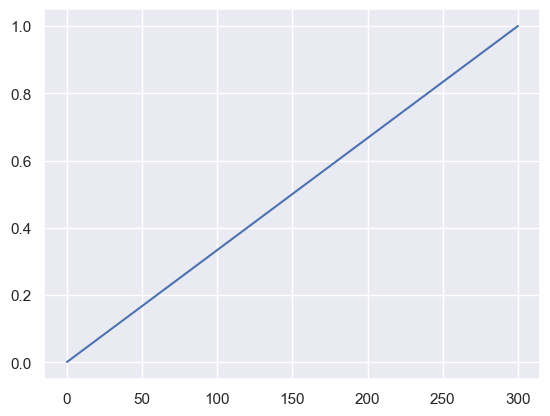

In [45]:
plt.plot(np.linspace(0.001, 1, window_size + 1))

In [77]:
n_components = 4
window_size = 300

a_cols = [f'a_{i}' for i in range(1, n_components + 1)]
b_cols = [f'b_{i}' for i in range(1, n_components + 1)]
p_cols = [f'probs_{i}' for i in range(1, n_components + 1)]
# sample_weights = np.array([1 - 0.95**k for k in range(1, window_size + 2)])
sample_weights = np.array([1] * (window_size + 1))
# sample_weights = np.linspace(0.001, 1, window_size + 1)
# sample_weights = np.array([k ** 0.5 for k in range(1, window_size + 2)])
sample_weights = sample_weights / np.sum(sample_weights)  # Нормализация

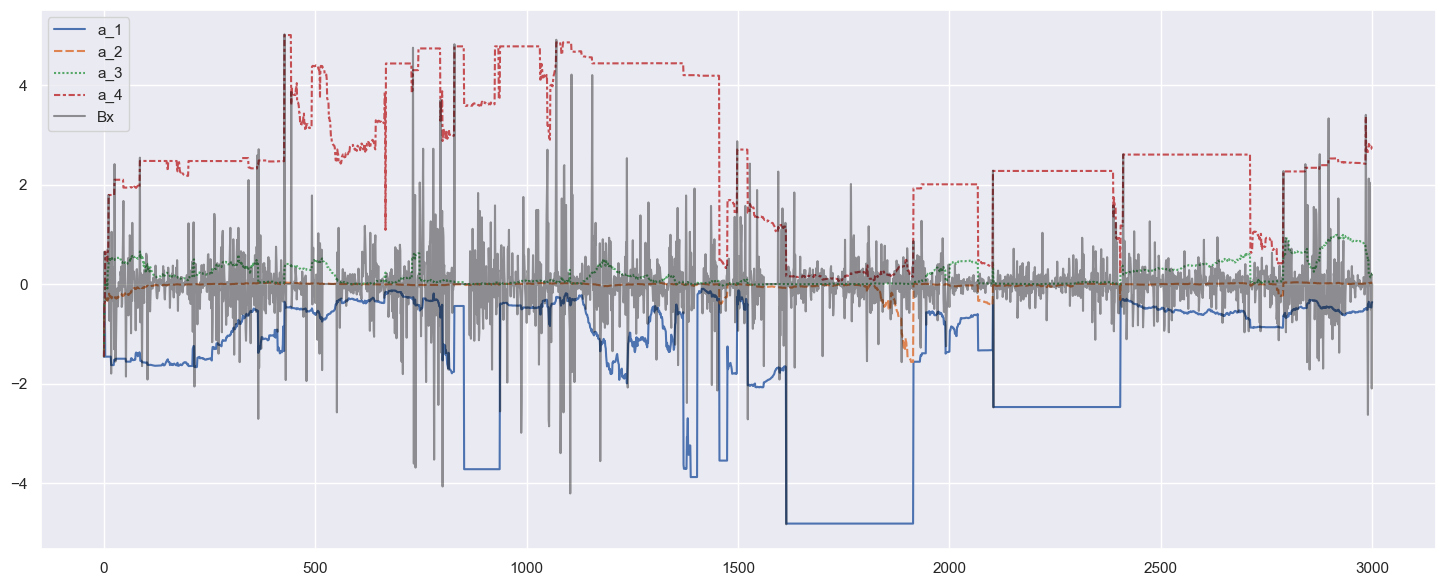

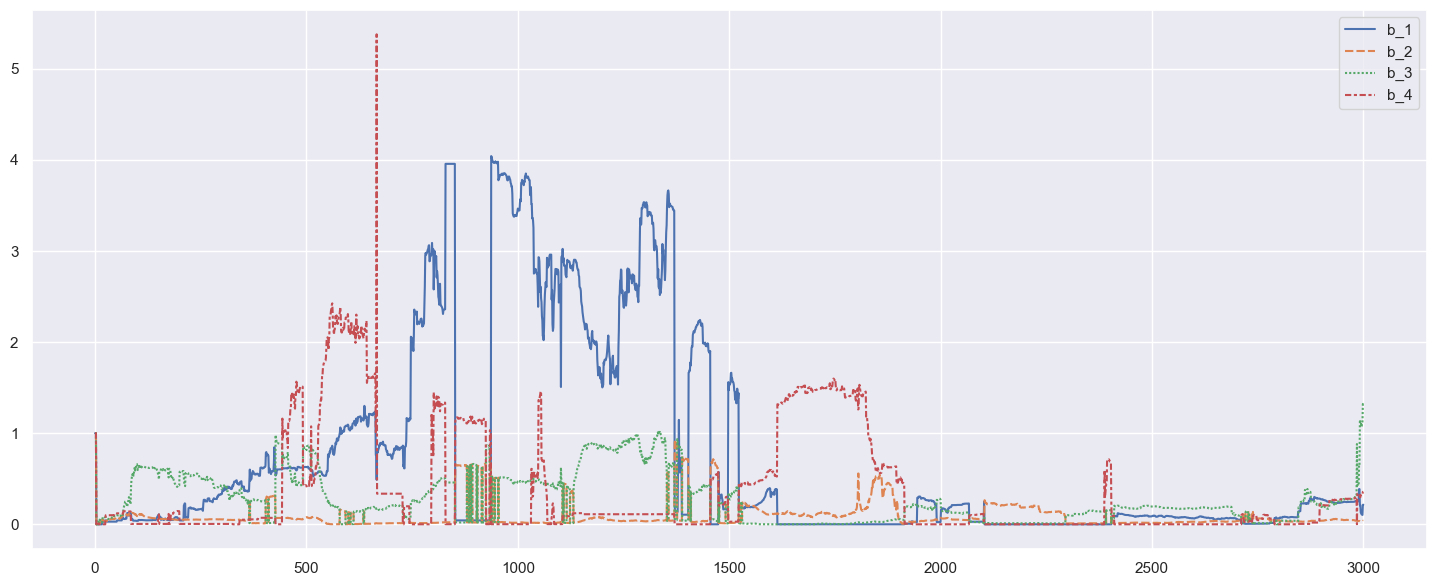

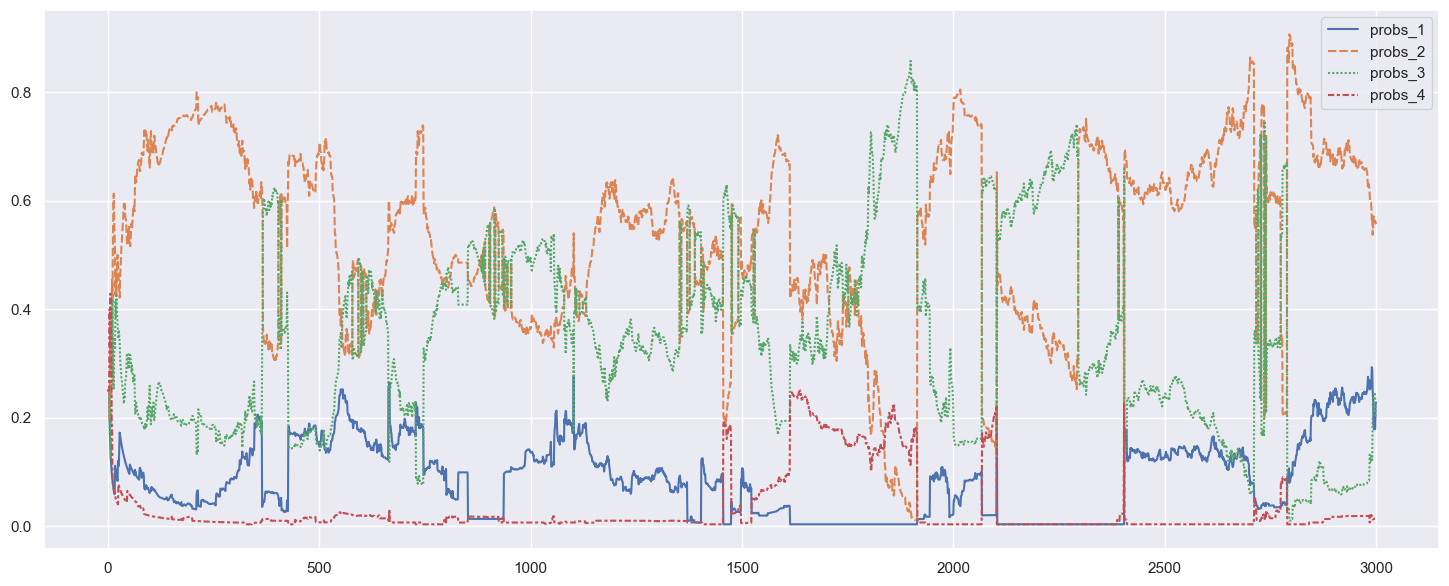

  0%|          | 3000/1664543 [00:04<37:47, 732.86it/s]


In [78]:
from tqdm import tqdm
from sklearn.mixture import GaussianMixture
from IPython.display import clear_output

coefs = [0] * len(data_diff)

prev_state = None

for shift in tqdm(range(len(data_diff))):
    left = max(shift - window_size, 0)
    right = shift + 1
    window = data_diff.iloc[left : right].values
    if window.shape[0] < n_components:
        X = window
        pi, mu, sigma =  np.array([1 / n_components] * n_components),\
                         np.expand_dims(np.array([np.mean(X)] * n_components), axis=1),\
                         np.expand_dims(np.expand_dims(np.array([1] * n_components), axis=1), axis=2)
    else:
        weights = sample_weights if shift >= window_size else np.array([1] * (shift + 1)) #np.array([1 - 0.95**k for k in range(1, shift + 2)])
        pi, mu, sigma = weighted_em_algorithm_numba(window, n_components, weights, max_iter=50)
        # prev_state = (pi, mu, sigma)
    cur = np.hstack([mu.flatten(), sigma.flatten(), pi])
    # assert(np.allclose(np.sum(pi), 1.0))
    if (shift == 0):
        coefs[shift] = GetProbOrdered(cur, n_components)
    else:
        cur = GetContigComponent(cur, coefs[shift-1], n_components)
    coefs[shift] = cur
    if (shift % 3000 == 0 and shift != 0):
        clear_output()
        plot_coefs(data_diff, coefs, shift)
        break
        # break
        # fig = PdfGmm(gmm, window)
        # wandb.log({f"window {shift}-{shift+100": wandb.Image(fig)})}

In [53]:
data_diff.iloc[74525 - 300:74525].value_counts()

Bx 
0.0    300
Name: count, dtype: int64

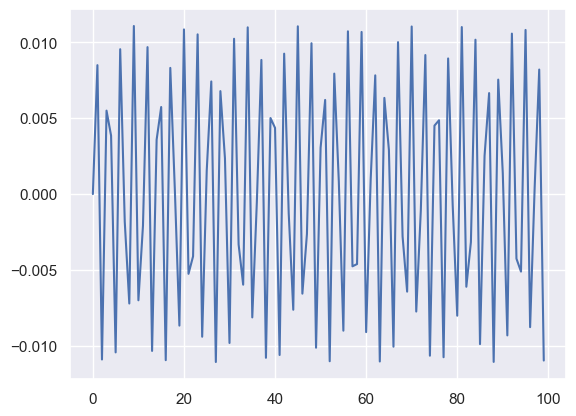

In [ ]:
plt.plot(enriched_data[:100, 6])

In [56]:
def coefs_to_pandas(coefs):
    return pd.DataFrame(coefs[: shift + 1],
        columns=[f'a_{i}' for i in range(1, n_components + 1)] +
                [f'b_{i}' for i in range(1, n_components + 1)] +
                [f'probs_{i}' for i in range(1, n_components + 1)]
    )

In [61]:
coefs_to_pandas(coefs).to_parquet('bx_coefs_3comp_300window_weights_expon_full.parquet')

In [ ]:
coefs = coefs_to_pandas(coefs)

In [ ]:
(coefs[[f'b_{i}' for i in range(1, 5)]] == 0).any(axis=1).sum()

np.int64(0)

In [ ]:
a, b, p = SplitCoefs(coefs.iloc[5].values)

In [ ]:
(a * p).sum()

np.float64(1.211388618703609)

In [ ]:
(b * p).sum()

np.float64(0.1188161588124347)

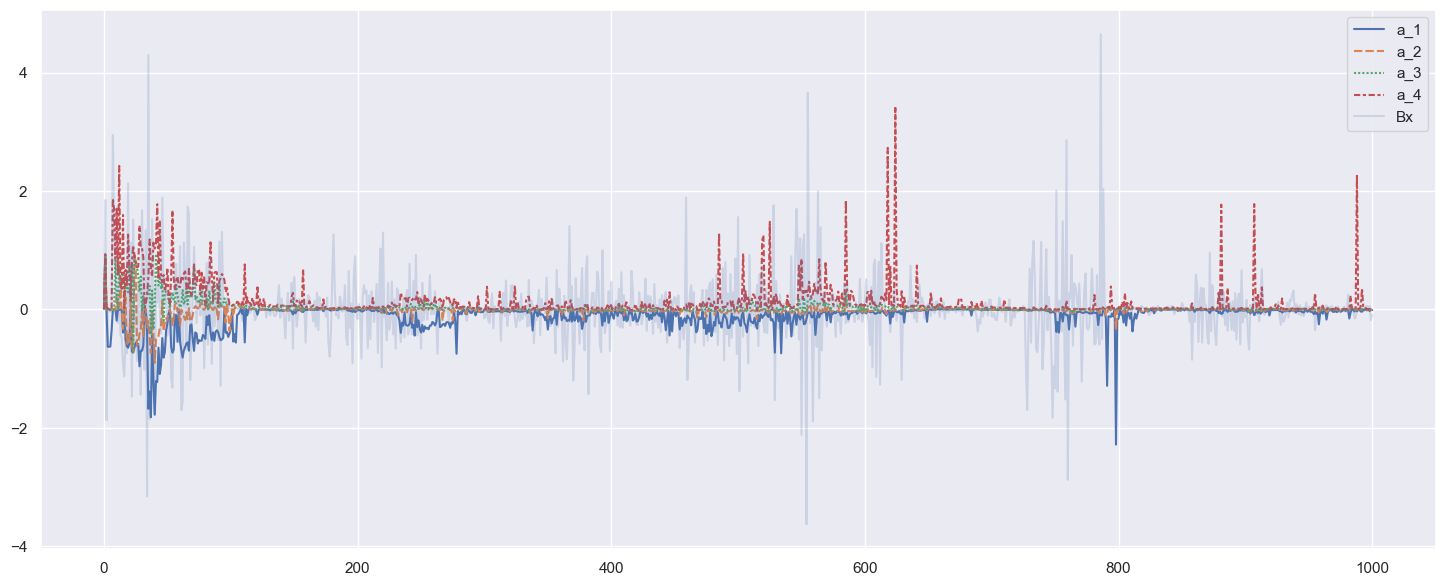

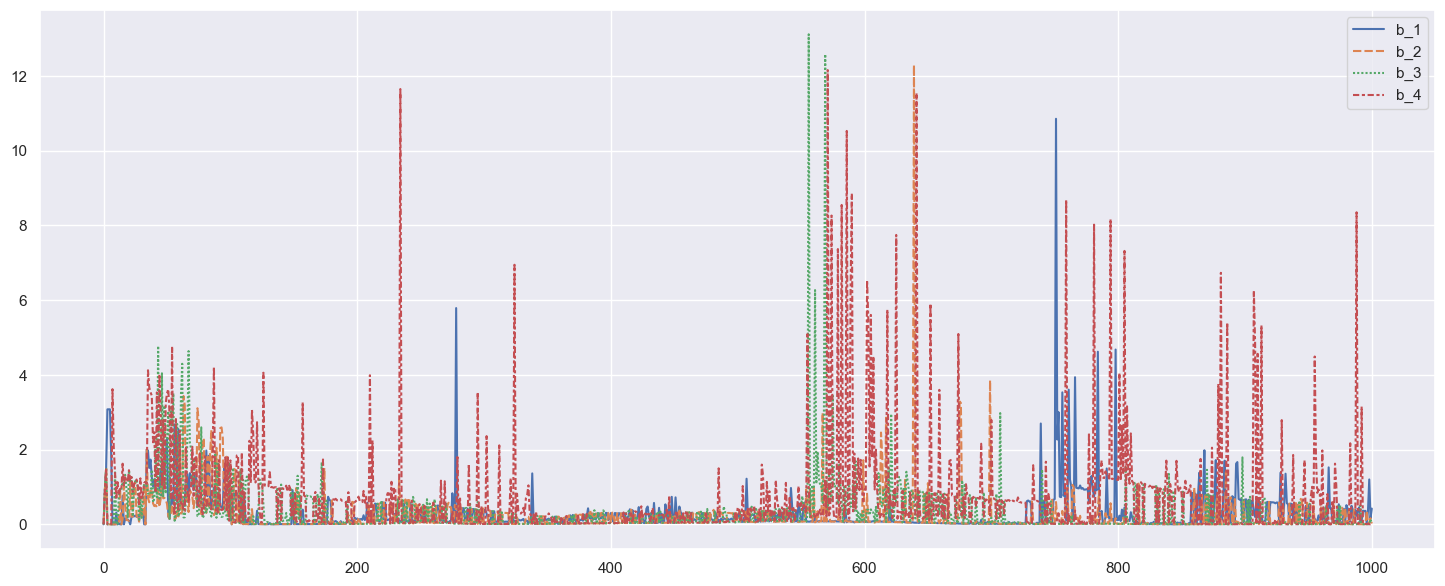

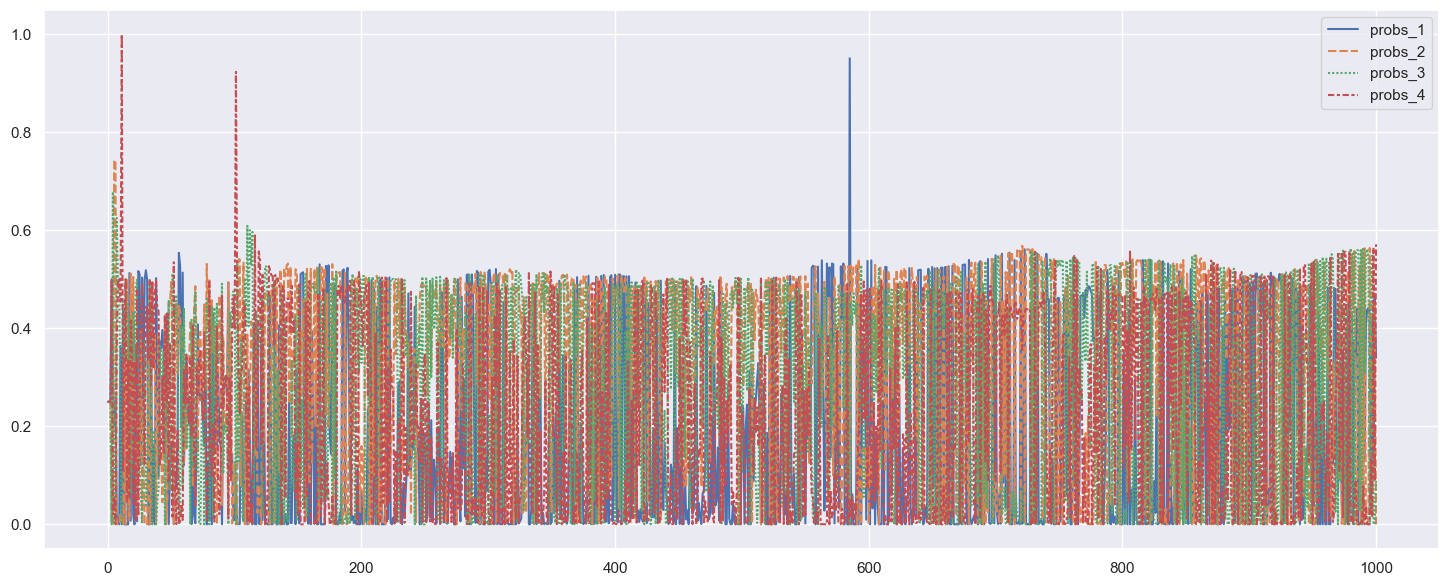

In [ ]:
shift = 1000
coefs = pd.DataFrame(coefs[: shift + 1],
    columns=[f'a_{i}' for i in range(1, n_components + 1)] +
            [f'b_{i}' for i in range(1, n_components + 1)] +
            [f'probs_{i}' for i in range(1, n_components + 1)]
)
sns.set_theme()
plt.figure(figsize=(18, 7))

sns.lineplot(data=coefs[a_cols])
sns.lineplot(data=data_diff[: shift + 1], alpha=0.2)
plt.show()
plt.figure(figsize=(18, 7))
sns.lineplot(data=coefs[b_cols])
plt.show()
plt.figure(figsize=(18, 7))
sns.lineplot(data=coefs[p_cols])
plt.show()